In [100]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy.stats import norm

plt.style.use('classic')
plt.rcParams["figure.figsize"] = (10,10)

def simple_read(file: str,sheet_index:int,column: str) -> np.ndarray: #получить чистый список магнитуд из файла
    try:
        data = pd.read_excel(file,sheet_name=sheet_index)  
    except Exception as exc:
        print('Ошибка во время чтения файла:',exc)
        
        
    # #TODO если не удалось найти ML, то изменить на другое
    try:
        
        raw_mag_column = data[column] #всё содержимое колонки
    except KeyError as err:
        print('ERROR:',err)
        print(f'Вероятнее всего, колонка с названием {column} не существует')
        

    numeric_mags = raw_mag_column[pd.to_numeric(raw_mag_column,errors='coerce').notnull()] #те элементы, которые безошибочно переводятся в число
    mag = np.array(numeric_mags,dtype=float)
    return mag

def calculate(mag: np.ndarray) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    
    mag_values = np.round(np.arange(min(mag),max(mag)+0.1,0.1),1) #значения с шагом в 0.1
    discrete_counts = np.array([np.count_nonzero(np.round(mag,1) == m) for m in mag_values]) #watch out for rounding; кол-во магнитуд из списка для каждого из mag_values
    N = len(mag)
    cumulative_counts = [N]
    for i in range(len(mag_values)):
        cumulative_counts.append(cumulative_counts[-1]-discrete_counts[i])
    cumulative_counts = np.array(cumulative_counts[:-1])
    #TODO проверка на адекватность: len(mag), sum(discrete_counts)
    return mag_values,discrete_counts,cumulative_counts

""" чтение подкаталога ECOS за 1991-2002, Assessing the Quality of Earthquake Catalogues: Estimating the Magnitude
of Completeness and Its Uncertainty by Jochen Woessner and Stefan Wiemer"""
def read_and_calculate_ecos(): 
    data = pd.read_csv('./catalogs/ecos 1991-2002.txt',delimiter=';')
    
    data = data[pd.to_numeric(data[' "Ml"'],errors='coerce').notnull()] #убираем все те данные, где магнитуда не приводится к числу
    
    mls = np.array(data[' "Ml"'],dtype=float)
    lats = np.array(data[' "lat"'],dtype=float)
    lons = np.array(data[' "lon"'],dtype=float)

    data.query("""0.4<=@mls<=4.2 & 45.9<=@lats<=46.65 & 6.8<=@lons<=8.4""",inplace = True) 
    """"отбор в соответствии с СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ ОЦЕНКИ МАГНИТУДЫ
    ПРЕДСТАВИТЕЛЬНОЙ РЕГИСТРАЦИИ ЗЕМЛЕТРЯСЕНИЙ
    © 2022 г. В. А. Павленко1,*, А. Д. Завьялов1,**, стр. 109"""
   
    mag = np.array(data[' "Ml"'],dtype=float)
    
    return (mag,*calculate(mag))

def MAXC(mag_values,discrete_counts):
    return mag_values[np.argmax(discrete_counts)]

def get_ab_values(mag: np.ndarray, M_co: float) -> tuple[float,float]: 
# оценки a,b методом максимального правдоподобия СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ ОЦЕНКИ МАГНИТУДЫ
#ПРЕДСТАВИТЕЛЬНОЙ РЕГИСТРАЦИИ ЗЕМЛЕТРЯСЕНИЙ стр 101.
    M_bin = 0.1 #интервал группировки
    M_filtered = mag[mag>=M_co] 
    M_mean = np.mean(M_filtered) 

    b_value = math.log10(math.e)/(M_mean-M_co+M_bin/2)
    N = len(M_filtered)
    try:
        a_value = math.log10(N)+b_value*M_co
    except ValueError as err:
        print('Ошибка во время счёта a_value:',err)
        if N==0:
            print('Вероятнее всего нельзя посчитать c заданным уровнем доверия')
    except Exception as exc:
        print('Ошибка во время определения a_value:',exc)


    return a_value, b_value

def Goodness_of_fit(mag,mag_values,discrete_counts,cumulative_counts):
    M_bin = 0.1
    
    mag = np.round(mag,1) #группируем все магнитуды округлением до M_bin
    M_co_start = min(mag) #значение магнитуды нижней отсечки
    M_array = np.arange(M_co_start,max(mag)+M_bin,0.1) #часть выборки с магнитудой m>=M_c
    R = np.array([])

    for M_co in np.round(np.arange(M_co_start,max(mag)+M_bin,M_bin),1): # округление нужно
        mag = mag[mag>=M_co]
        a,b = get_ab_values(mag,M_co)
        
        #синтетические кумулятивные значения в соответствии с законом повторяемости 
        N_array = S = 10**(a-b*M_array)
        M_array = M_array[1:]

        B = cumulative_counts[np.where(mag_values == M_co)[0][0]:]
        
        R_last = 100- np.sum( np.abs(B - S))/sum(cumulative_counts)*100
        R = np.append(R,R_last)
        
        if R_last >= 95:
            return M_co
        #TODO draw Residual (100-R) as a function of minimum magnitude cutoff
    return R

def LLS(mag,mag_values):
    
    M_bin = 0.1
    n = len(mag_values) # number of bins. #? must change with every step of M_co
    M_co_start = round(min(mag),1) #round down to catch all values?
    M_co_finish = round(max(mag),1)
    M_co_to_test = np.array(np.arange(M_co_start,M_co_finish,M_bin)) # ? M_co_finish+M_bin: 5.1 is not for tesst
    
    _2QI = []
    I_list = []
    t_list = []
    
    for M_co in M_co_to_test:
        
        
        # ? redo n definition
        mag = mag[mag>=M_co] # ?
        M_i_array = np.array([M_co+i*M_bin for i in range(0,n+1)])
        # N_array = np.array([np.count_nonzero((M_co+i*M_bin-M_bin/2 <=mag) & (mag <=M_co+i*M_bin+M_bin/2)) for i in range(n)]) # TODO redo with new definition of M_i_array
        N_array = np.array([np.count_nonzero((mag >= M_i-M_bin/2) & (mag<=M_i+M_bin/2)) for M_i in M_i_array]) # redon with new definition of M_i_array
        # ? mag <= or mag < : possible double count
        
        Q_0 = sum(N_array)
        P = N_array/Q_0
        P[P==0]=0.0000000000001 #log of 0 is not defined
        
        try:
            a,b = get_ab_values(mag,M_co)
        except:
            print('Не могу посчитать a,b в методе LLS(1)')
            print(f"Если значение M = {round(M_co,1)} близко к максимальному значению в выборке ({max(mag_values)}), значит не получается посчитать методом LLS с заданным уровнем доверия")
            return 'error1'

        PIE =10**(-b*(M_i_array-M_co))/sum(10**(-b*(M_i_array-M_co))) #wrong expression in 2022 there it's e in the denominator
        I=  np.sum(P*np.log(P/PIE))
        #если уровень значимости ниже, от отвергаем гипотезу о прямолинейности ??
        # TODO систематическое смещение
        
        if I<0.05:
            # print('by I')
            return round(M_co,1)
        I_list.append(I)

        ##################ВЫЯСНЕНИЕ ПРИЧИНЫ НЕЛИНЕЙНОСТИ#####################
        try:
            a,b = get_ab_values(mag[mag>=M_co+M_bin],M_co)
        except:
            print('Не могу посчитать a,b в методе LLS(2)')
            print(f"Если значение M = {round(M_co,1)} близко к максимальному значению в выборке ({max(mag_values)}), значит не получается посчитать методом LLS с заданным уровнем доверия")
            return 'error'
        X_i_array = 10**(-b*(M_i_array-M_co))
        # psi = np.array([sum(i**k*X_i_array) for k in [0,1,2]]) 
        psi = np.array([])
        for k in [0,1,2]:
            summa = 0
            for i in range(1,len(M_i_array)):
                summa+= i**k*X_i_array[i]
            psi = np.append(psi,summa)
        
        
        p_hat = N_array[0]*psi[0]/(Q_0-N_array[0])
        
        Var_p_hat = (N_array[0]*psi[0]**2/(Q_0-N_array[0])**2) + ((N_array[0]**2*psi[0]**3*psi[2])/((Q_0-N_array[0])**3*(psi[0]*psi[2]-psi[1]**2)**2))

        t = (1-p_hat)/(Var_p_hat)**0.5
        # print('t',round(t,2))
        if t < 0.95:
            # print('by t')
            return round(M_co,1)

        t_list.append(t)
        
    return 'couldnt'

def draw(mag_values,discrete_counts,cumulative_counts,M_MAXC=0,M_LLS=0,M_GFT=0,a=0,b=0):

    filename_to_open = 'placceholder'
    chosen_sheetname = 'placceholder'
    fig, ax = plt.subplots()
    
    plt.scatter(mag_values,discrete_counts,marker="^",s=40)
    plt.yscale('log')
    plt.xlim(min(mag_values)-0.1,max(mag_values)+0.1)
    plt.ylim(1,max(cumulative_counts)+0.1*max(cumulative_counts))
    plt.grid()
    
    M = np.arange(0,6,0.1)
    N = 10**(a-b*M)
    plt.plot(M,N)
    
    plt.scatter(mag_values,cumulative_counts)

    # TODO add their xticks
    plt.plot([M_MAXC,M_MAXC],[-1,10**4],c='green')
    plt.plot([M_GFT,M_GFT],[-1,10**4],c='red')
    plt.plot([M_LLS,M_LLS],[-1,10**4],c='blue')

    text = AnchoredText(f"{filename_to_open}\n{chosen_sheetname}\n{M_MAXC=}\n{M_LLS=}\n{M_GFT=}", 
                    prop=dict(size=11), frameon=True,loc='upper right',
                    )
    text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(text)

    # mu = 1.1
    # sigma = 0.25
    mu,sigma = norm.fit(discrete_counts)
    norma = norm(loc = mu,scale = sigma)
    plt.plot(mag_values,norma.cdf(mag_values))
    plt.show()

def EMR(mag,mag_values,discrete_counts):
    likelihood_function = np.array([])
    M_bin = 0.1
    for M_co in mag_values:
        mag_to_test_less_M_co = mag[mag<M_co]
        mag_to_test_more_M_co = mag[mag>=M_co]
        mu,sigma = norm.fit(mag_to_test_less_M_co)
        lamb_less_M_co = norm.cdf(mag_values[mag_values<M_co],mu,sigma)
        a,b = get_ab_values(mag_to_test_more_M_co,M_co)
        beta  = b * math.log(10)
        lamb_more_M_co = np.exp(-beta*(mag_values[mag_values>=M_co]-M_co))
        lamb = np.append(lamb_less_M_co,lamb_more_M_co)
        likelihood_function = np.append(likelihood_function,np.sum(np.log(lamb)))
        print(M_co,likelihood_function)
    plt.plot(mag_values,likelihood_function)
        
        

1.2
1.0
1.2


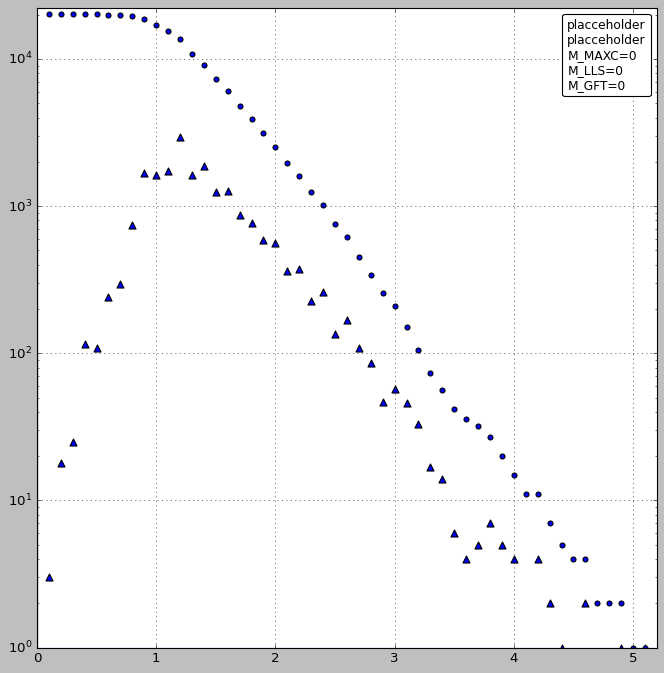

In [105]:
mag = simple_read(file = './catalogs/NCSN.xlsx',sheet_index=0,column='Mag')
mag_values,discrete_counts,cumulative_counts = calculate(mag)
# mag,mag_values,discrete_counts,cumulative_counts = read_and_calculate_ecos()
M_MAXS = MAXC(mag_values,discrete_counts)
print(M_MAXS)
M_GFT = Goodness_of_fit(mag,mag_values,discrete_counts,cumulative_counts)
print(M_GFT)
M_LLS=LLS(mag,mag_values)
print(M_LLS)
draw(mag_values,discrete_counts,cumulative_counts)

0.1 [-95.18710047]
0.2 [ -95.18710047 -103.4942364 ]
0.3 [ -95.18710047 -103.4942364  -109.14648305]
0.4 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158]
0.5 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359]
0.6 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359
 -138.65821956]
0.7 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359
 -138.65821956 -150.37326114]
0.8 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359
 -138.65821956 -150.37326114 -164.63252533]
0.9 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359
 -138.65821956 -150.37326114 -164.63252533 -183.34267321]
1.0 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359
 -138.65821956 -150.37326114 -164.63252533 -183.34267321 -199.81273831]
1.1 [ -95.18710047 -103.4942364  -109.14648305 -116.81402158 -128.73754359
 -138.65821956 -150.37326114 -164.63252533 -183.34267321 -199.81273831
 -209.53970662]
1.2 

c:\Users\cambo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:367: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
c:\Users\cambo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\cambo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:372: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


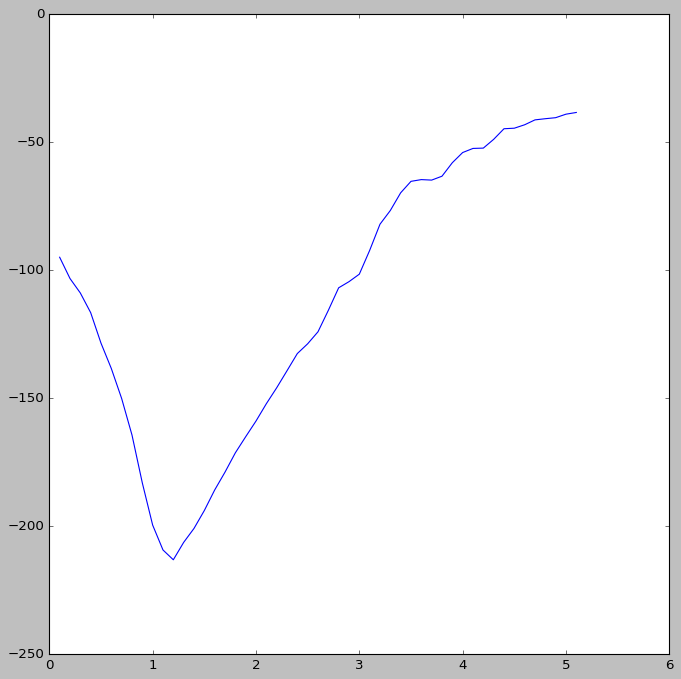

In [106]:
EMR(mag,mag_values,discrete_counts)

In [ ]:
# ok_mag_values = mag_values[mag_values<1.3]
# mu,sigma = norm.fit(discrete_counts[0:len(ok_mag_values)])
# norma = norm(loc = mu,scale = sigma)
# plt.plot(ok_mag_values,norm.pdf(ok_mag_values,mu,sigma))
# print(mu,sigma)
# plt.scatter(ok_mag_values,discrete_counts[0:len(ok_mag_values)])
mu,sigma = norm.fit(mag[mag<1.2])
x = np.linspace(0,1.2,100)
mag_values = mag_values[mag_values<1.2]
plt.plot(mag_values,3000*norm.cdf(mag_values,mu,sigma))
plt.scatter(mag_values,discrete_counts[0:len(mag_values)])
# print(discrete_counts[0:len(ok_mag_values)])
print(mu)

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = norm.rvs(10.0, 2.5, size=500)

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
# plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
# xmin, xmax = plt.xlim()
x = np.linspace(0, 20, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
print(data)
plt.show()